# Load the data and prepare it for further analysis
Parse the CSV files within the ../results folder and load them into data frames.
Preprocess the data frames by ensuring that all data frames have the following column names: 
- 'doi':
- 'url':
- 'title':
- 'abstract': 
- 'bibtex':
- 'source':
- 'year':

In [75]:
from pathlib import Path
import pandas as pd

RESULTS_FOLDER = Path("../results/")
 
# load the data frames
df_arxiv = pd.read_csv(RESULTS_FOLDER / 'arxiv_2024-06-26_14-50-21.csv')
df_springer = pd.read_csv(RESULTS_FOLDER / 'springer_2024-06-26_14-45-54-Fixed.csv')
df_ieee = pd.read_csv(RESULTS_FOLDER / 'IEEE_export2024.06.26-16.05.03-Fixed.csv')
df_acm = pd.read_csv(RESULTS_FOLDER / 'acm_export2024.07.02-16.14.csv')
df_science_direct = pd.read_csv(RESULTS_FOLDER / 'ScienceDirect_2024-06-26_17-18-04.csv')
df_web_of_science = pd.read_csv(RESULTS_FOLDER / 'webofscience_2024-06-26_16-57-54-Fixed.csv')
df_acl = pd.read_csv(RESULTS_FOLDER / 'ACL_2024-07-02-Fixed.csv')
df_scopus = pd.read_csv(RESULTS_FOLDER / 'Scopus_2024-07-02.csv')

# add source to all data frames
df_arxiv['source'] = 'arxiv'
df_springer['source'] = 'springer'
df_ieee['source'] = 'ieee'
df_acm['source'] = 'acm'
df_science_direct['source'] = 'science_direct'
df_web_of_science['source'] = 'web_of_science'
df_acl['source'] = 'acl'
df_scopus['source'] = 'scopus'

# ensure all frames have a title
df_ieee = df_ieee.rename(columns={'Document Title': 'title'})
df_web_of_science = df_web_of_science.rename(columns={'Article Title': 'title'})

# ensure all frames have a doi column and are of type string
df_arxiv['doi'] = df_arxiv['doi'].fillna("").astype(str)
df_springer['doi'] = df_springer['DOI'].fillna("").astype(str)
df_ieee['doi'] = df_ieee['DOI'].fillna("").astype(str)
df_acm['doi'] = df_acm['doi'].fillna("").astype(str)
df_science_direct['doi'] = df_science_direct['doi'].fillna("").astype(str)
df_web_of_science['doi'] = df_web_of_science['DOI'].fillna("").astype(str)
df_acl['doi'] = df_acl['doi'].fillna("").astype(str)
df_scopus['doi'] = df_scopus['doi'].fillna("").astype(str)


# ensure all frames have a URL column 
df_springer['url'] = df_springer['link'].apply(lambda x: x if "link.springer.com" in x else "https://link.springer.com" + x)
df_ieee = df_ieee.rename(columns={'PDF Link': 'url'})
df_web_of_science = df_web_of_science.rename(columns={'DOI Link': 'url'})

# ensure all frames have an abstract column
df_ieee = df_ieee.rename(columns={'Abstract': 'abstract'})
df_web_of_science = df_web_of_science.rename(columns={'Abstract': 'abstract'})

# add year column to data frames if not present
df_arxiv['year'] = df_arxiv['published'].apply(lambda x: x.split("-")[0].strip())
df_springer['year'] = df_springer['published'].apply(lambda x: x.split(" ")[-1].strip())
df_ieee['year'] = df_ieee['Publication Year'].apply(lambda x: str(x).strip())
df_science_direct['year'] = df_science_direct['year'].astype(str)
df_acm['year'] = df_acm['year'].astype(str)
df_web_of_science['year'] = df_web_of_science['Publication Year'].apply(lambda x: str(x).strip())
df_acl['year'] = df_acl['year'].astype(str) 
df_scopus['year'] = df_scopus['year'].astype(str)

# print counts
print(f"ArXiv # papers: {df_arxiv.shape}")
print(f"Springer # papers: {df_springer.shape}")
print(f"IEEE # papers: {df_ieee.shape}")
print(f"ACM # papers: {df_acm.shape}")
print(f"Science Direct # papers: {df_science_direct.shape}")
print(f"Web of Science # papers: {df_web_of_science.shape}")
print(f"ACL # papers: {df_acl.shape}")
print(f"Scopus # papers: {df_scopus.shape}")

# sum the number of papers
total_papers = df_arxiv.shape[0] + df_springer.shape[0] + df_ieee.shape[0] + df_acm.shape[0] + df_science_direct.shape[0] + df_web_of_science.shape[0] + df_acl.shape[0] + df_scopus.shape[0]
print(f"Total number of papers: {total_papers}")

ArXiv # papers: (162, 8)
Springer # papers: (241, 12)
IEEE # papers: (73, 32)
ACM # papers: (526, 26)
Science Direct # papers: (387, 23)
Web of Science # papers: (74, 76)
ACL # papers: (79, 9)
Scopus # papers: (193, 9)
Total number of papers: 1735


# Merge the data frames
This will merge the data frames and remove duplicates.
We will keep only the columns:
- title
- doi
- year
- source
- url

In [121]:
# Merge the data frames
data_frames = [df_arxiv, df_springer, df_ieee, df_acm, df_science_direct, df_web_of_science, df_acl, df_scopus]
columns = ['title', 'url',  'doi', 'source',  'year', 'bibtex']
df_merged_subset = pd.concat([df[columns] for df in data_frames], ignore_index=True)
print(f"Total number of papers before removing duplicates: {df_merged_subset.shape[0]}")

# Filter out rows where DOI is None or empty string for concatenation purposes
df_valid = df_merged_subset[df_merged_subset['doi'].notna() & df_merged_subset['doi'].str.strip().astype(bool)]
df_invalid = df_merged_subset[df_merged_subset['doi'].isna() | df_merged_subset['doi'].str.strip().eq('')]

# Group by DOI and concatenate the 'source' column
df_grouped = (df_valid.groupby('doi')
              .agg({'title': 'first', 'year': 'first', 'source': ', '.join,'url': 'first','bibtex':'first'})
              .reset_index())

# Concatenate the grouped and invalid DataFrames
df_merged_subset = pd.concat([df_grouped, df_invalid], ignore_index=True)
# save to CSV starting index from 1
df_merged_subset.index = range(1, len(df_merged_subset) + 1)
# name the column index as id
df_merged_subset.index.name = 'id'

df_merged_subset.to_csv("../results/llm_education_survey_paper.csv", index=True)


print(f"Number of papers with valid DOI: {df_valid.shape[0]}")
print(f"Number of papers with invalid DOI: {df_invalid.shape[0]}")
print(f"Total number of papers after removing duplicates: {df_merged_subset.shape[0]}")

df_merged_subset

# find all papers published from 2019 and onwards
df_merged_subset['year'] = df_merged_subset['year'].astype(int)
df_merged_subset[df_merged_subset['year'] >= 2019].to_csv("../results/llm_education_survey_paper_after_2019.csv", index=True)

Total number of papers before removing duplicates: 1735
Number of papers with valid DOI: 1665
Number of papers with invalid DOI: 70
Total number of papers after removing duplicates: 1557


# Visualize results and raw data

## Plot the distribution of papers per source

[Text(0, 0, '526'),
 Text(0, 0, '387'),
 Text(0, 0, '241'),
 Text(0, 0, '193'),
 Text(0, 0, '162'),
 Text(0, 0, '79'),
 Text(0, 0, '74'),
 Text(0, 0, '73')]

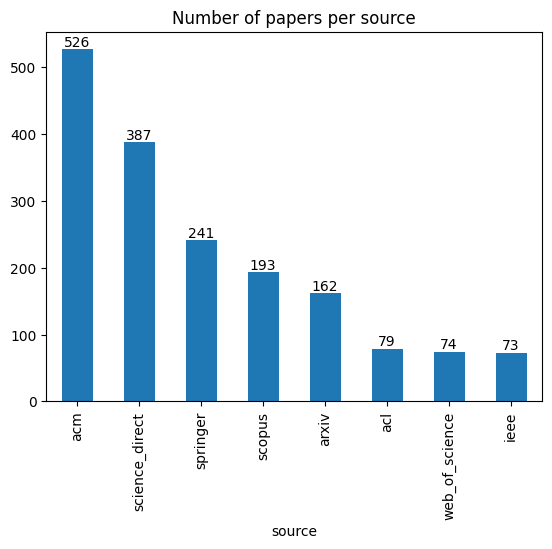

In [89]:
df_sources = pd.DataFrame({'source': ['arxiv', 'springer', 'ieee', 'acm', 'science_direct', 'web_of_science', 'acl', 'scopus'],
                           'count': [df_arxiv.shape[0], df_springer.shape[0], df_ieee.shape[0], df_acm.shape[0], df_science_direct.shape[0], df_web_of_science.shape[0], df_acl.shape[0], df_scopus.shape[0]]})
# sort the values
df_sources = df_sources.sort_values(by='count', ascending=False)
ax=df_sources.plot(kind='bar', x='source', y='count', title='Number of papers per source', legend=False)
# show the actual values in the plot bars
ax.bar_label(ax.containers[0])

## Visualize the datasets (papers / year)

In [91]:
# count numbers of papers per year
df_arxiv_year = df_arxiv.groupby('year').count()
df_springer_year = df_springer.groupby('year').count()
df_ieee_year = df_ieee.groupby('year').count()
df_acm_year = df_acm.groupby('year').count()
df_science_direct_year = df_science_direct.groupby('year').count()
df_web_of_science_year = df_web_of_science.groupby('year').count()
df_acl_year = df_acl.groupby('year').count()
df_scopus_year = df_scopus.groupby('year').count()

# remove unnecessary columns
df_arxiv_year = df_arxiv_year[['title']]
df_springer_year = df_springer_year[['title']]
df_ieee_year = df_ieee_year[['title']]
df_acm_year = df_acm_year[['title']]
df_acl_year = df_acl_year[['title']]
df_scopus_year = df_scopus_year[['title']]
df_science_direct_year = df_science_direct_year[['title']]
df_web_of_science_year = df_web_of_science_year[['title']]


# merge the counts
df_arxiv_year = df_arxiv_year.rename(columns={'title': 'arxiv'})
df_springer_year = df_springer_year.rename(columns={'title': 'springer'})
df_ieee_year = df_ieee_year.rename(columns={'title': 'ieee'})
df_acm_year = df_acm_year.rename(columns={'title': 'acm'})
df_science_direct_year = df_science_direct_year.rename(columns={'title': 'science_direct'})
df_web_of_science_year = df_web_of_science_year.rename(columns={'title': 'web_of_science'})
df_acl_year = df_acl_year.rename(columns={'title': 'acl'})
df_scopus_year = df_scopus_year.rename(columns={'title': 'scopus'})

df_merged = pd.concat([df_arxiv_year['arxiv'], df_springer_year['springer'], df_ieee_year['ieee'], df_acm_year['acm'],
                       df_science_direct_year['science_direct'], df_web_of_science_year['web_of_science'],
                       df_acl_year['acl'], df_scopus_year['scopus']],
                      axis=1)
df_merged = df_merged.fillna(0)
df_merged = df_merged.astype(int)

# sort the years
df_merged = df_merged.sort_index()
df_merged

,arxiv,springer,ieee,acm,science_direct,web_of_science,acl,scopus
year,,,,,,,,
1948,0,0,0,0,0,0,0,1
1972,0,0,0,1,0,0,0,0
1978,0,0,0,0,1,0,0,0
1981,0,0,0,0,2,0,0,0
1982,0,2,0,0,2,0,0,0
1984,0,0,0,0,1,0,0,0
1985,0,1,0,0,0,0,0,0
1987,0,0,0,0,2,0,0,0
1988,0,0,0,0,5,0,0,0


In [92]:
# count the number of papers whose year >= N
df_merged['total'] = df_merged['arxiv'] + df_merged['springer'] + df_merged['ieee'] + df_merged['acm'] + df_merged['science_direct'] + df_merged['web_of_science'] + df_merged['acl'] + df_merged['scopus']
all = df_merged['total'].sum()
cut_off_year = 2019
after_cut_off_year = df_merged.loc[df_merged.index.astype(int) >= cut_off_year].sum()
print(f"Total number of papers: {all}")
print(f"Number of papers after {cut_off_year}: {after_cut_off_year['total']}")

Total number of papers: 1729
Number of papers after 2019: 1624


[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '4'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '5'),
 Text(0, 0, '8'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '6'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '8'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '5'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '8'),
 Text(0, 0, '11'),
 Text(0, 0, '36'),
 Text(0, 0, '553'),
 Text(0, 0, '1014')]

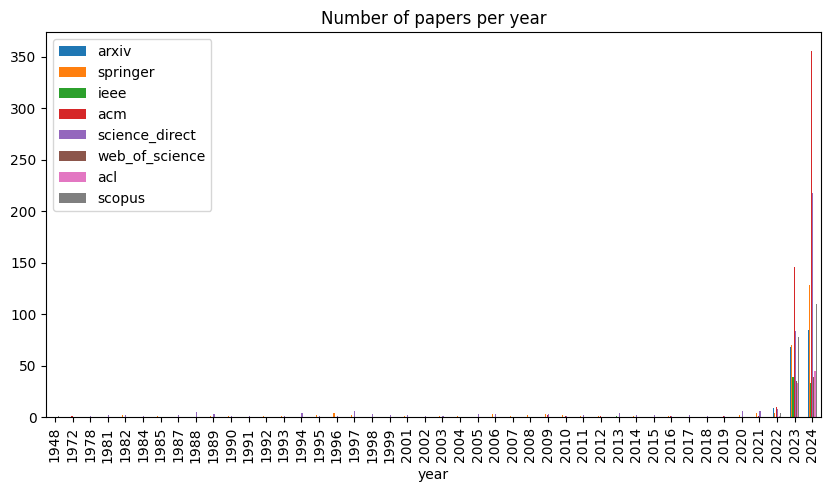

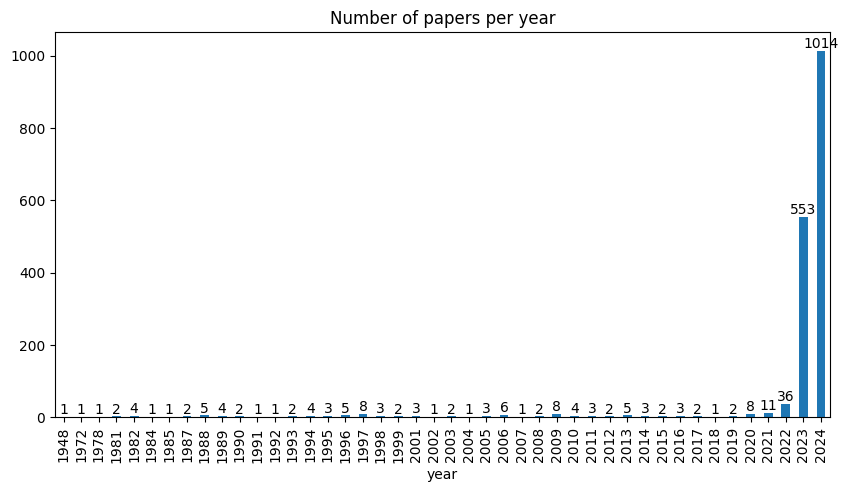

In [94]:
# exclude total column & plot
df_merged.drop(columns=['total']).loc[df_merged.index.astype(int) >= 1].plot(kind='bar', figsize=(10, 5),
                                                                             title='Number of papers per year')

ax=df_merged[['total']].loc[df_merged.index.astype(int) >= 1].plot(kind='bar', figsize=(10, 5),
                                                                             title='Number of papers per year', legend=False)
ax.bar_label(ax.containers[0])

In [81]:
# find papers with the keyword 'survey' in the title (case-insensitive search)
df_surveys = df_merged_subset[df_merged_subset['title'].str.contains('survey', case=False, na=False)]
df_surveys

,title,bibtex_id,url,type,doi,is_relevant,source,year
id,,,,,,,,
90,Value-Based Adoption of ChatGPT in Agile Softw...,None,https://link.springer.com/chapter/10.1007/978-...,None,10.1007/978-3-031-55642-5_12,None,springer,2024
151,A survey on sentiment analysis and its applica...,None,https://link.springer.com/article/10.1007/s005...,None,10.1007/s00521-023-08941-y,None,springer,2023
158,Situational Data Integration in Question Answe...,None,https://link.springer.com/article/10.1007/s101...,None,10.1007/s10115-024-02136-0,None,springer,2024
170,A survey of safety and trustworthiness of larg...,None,https://link.springer.com/article/10.1007/s104...,None,10.1007/s10462-024-10824-0,None,springer,2024
205,A survey on large language model based autonom...,None,https://link.springer.com/article/10.1007/s117...,None,10.1007/s11704-024-40231-1,None,springer,2024
217,A Large Language Model Approach to Educational...,None,https://link.springer.com/article/10.1007/s405...,None,10.1007/s40593-024-00414-0,None,springer,2024
298,Large Language Models for Software Engineering...,None,https://ieeexplore.ieee.org/stamp/stamp.jsp?ar...,None,10.1109/ICSE-FoSE59343.2023.00008,None,"ieee, web_of_science, scopus",2023
488,Moving From Narrative to Interactive Multi-Mod...,None,https://doi.org/10.1145/3610288,None,10.1145/3610288,None,acm,2023
614,MetaFraming: A Methodology for Democratizing H...,None,https://doi.org/10.1145/3623462.3623465,None,10.1145/3623462.3623465,None,acm,2023
